**Step 1: data pre-process steps and initial feature extraction**<br/>
* add aggregate- copy do_aggregate_steps from main

**Step 2: Data insights and visualization including drop outliers**<br/>
* Basic stats, dividends per year, abnormal return hist given div direction<br/>
* Moved outliers to beginning


**Step 3: Base line model**<br/>
* Should we split train/test in the research linear regression? same for the regular one
* Which columns should I drop?
* Do year, month, quarter dummies


**Step 4: Analysis of error + conclusions (years 2008-2009)**<br/>
* fix error by year plot


**Step 5: Sensitivity analysis (size of window)**


**Step 6: Run new model (Regression) (naive + feature handler)**


**Step 7: Run different Regression models and compare**


**Step 8: Discrete Models**


**Step 9: Cross Validation, results and conclusions**


In [13]:
import imp
imp.reload(main)
imp.reload(regression_models)
imp.reload(feature_handler)

<module 'feature_handler.feature_handler' from 'C:\\Users\\Owner\\GIT\\DS3\\DataSci\\feature_handler\\feature_handler.py'>

In [1]:
from aggregate import aggregate
from aggregate import capm_params
from feature_handler import feature_handler
from run_model import regression_models
from visualize import visualize
import pandas as pd
import numpy as np
import main
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

# Data Science Workshop - Project notebook

**TODO: introduction**

### Step 0: Notebook Intialization
seed: 
>We ran the notebook using seed = 10

run_speed:
>3 - fastest (immediate)<br/>
    2 - avrage<br/>
    1 - slowest

In [2]:
seed = 10
random.seed(seed)
np.random.seed(seed)
run_speed = 3

### Step 1: data pre-process steps and initial feature extraction

In [3]:
df = pd.read_csv("aggregated_data.csv")
display(df.head(1))

,company_name,symbol,industry,sector,dividend_date,dividend_amount,alpha,beta,price_t-5,vol_t-5,...,year,month,quarter,MV Debt Ratio,BV Debt Ratio,Effective Tax Rate,Std Deviation In Prices,EBITDA/Value,Fixed Assets/BV of Capital,Capital Spending/BV of Capital
0,"American Airlines Group, Inc.",AAL,Air Freight/Delivery Services,Transportation,2019-10-22,$0.10,-33.847291,0.020567,27.93,6709600.0,...,2019,10,4,0.229,0.558,0.084,0.385,0.1,0.319,0.047


In the data each sample is a specific dividend announcment of some company.
For each sample we have:
* **company_name , symbol**
* **sector , industry** - sector is more general, while industry is more specific
* **dividend_date** - the declaration date of the dividend.
* **dividend_amount** - the amount (in USD) of the dividend per share.
* **alpha, beta** - the coefficients of the CAPM (as calculated above) model (more on that in the PDF documentation)<br/>


* **price_t-i ,price_t+i** - the actual stock price i days before/after the declaration (for $i\in\{0,...,5\}$)
* **expected_t-i ,expected_t+i** - the expected stock price (using CAPM model) i days before/after the declaration: $expected\_i = \alpha + \beta*sp\_i$ (for $i\in\{0,...,5\}$)
* **vol_t-i ,vol_t+i** - the trade volume of the stock, i days before/after the declaration (for $i\in\{0,...,5\}$)
* **sp_price_t-i ,sp_price_t+i** - the S&P500 price i days before/after the declaration (for $i\in\{0,...,5\}$)
* **sp_vol_t-i ,sp_vol_t+i** - the trade volume of S&P500, i days before/after the declaration (for $i\in\{0,...,5\}$)


* **MV Debt Ratio,BV Debt Ratio, Effective Tax Rate, Std Deviation In Prices, EBITDA/Value, Fixed Assets/BV of Capital, Capital Spending/BV of Capital** - all those are financial ratios, more on that on the PDF documentation.<br/>



In [4]:
_ = main.print_basic_stats(df)

Data Stats:
	#Samples: 39913
	#Features: 62
	#Samples with NaNs: 86


Next - intial data pre-processing:
1. Drop NaNs - We don't have alot of samples with NaNs, hence droping them seems like the right way to handle them.
2. Handle data types - basic conversion from string to float.
3. Add additional features (on top of what was previously added by the aggregate procedure function):
>**dividend change** - $\frac{current\_dividend\_amount-previous\_dividend\_amount}{previous\_dividend\_amount}$ -  In case no previous dividend exists - set as 1.<br/> **dividend change direction** - the direction of the change vs. previous announcment (1: increase, -1: decrease, 0: unchanged),  In case no previous dividend exists - set as 1 (increase).<br/>
4. Calculate abnormal return related features:
>**abnormal return**: $ar\_ti = expected\_i - price\_i$ for $i\in\{-5,...,5\}$<br/> **average abnormal return**: $aar\_i = \frac{\sum_{k=-i}^i{ar_k}}{2i+1}$ for $i\in\{0,...,5\}$<br/>

In order to be aligned with previous empirical financial studies, we intially fix our response as "aar_5".<br/>
("aar_i%" will be discussed later)

In [5]:
#run this twice will cause error!
main.step1_wrapper(df, run_speed = run_speed)
_ = main.print_basic_stats(df)

Dropped 86 rows with NaN values
Created: div_direction, div_change
Created: expected_t, ar_t, aar_t, aar_t%

Data Stats:
	#Samples: 39746
	#Features: 98
	#Samples with NaNs: 0


In [6]:
df['div_change'].min(), df['div_change'].max()

(-0.9999886144982979, 28970.999999999993)

We have ~40K samples, 98 featuers, and non missing values.<br/>
At this point we want to point out that not all the features are valid for use in prediction of "aar_5", some of them already contains information about it - for example "aar_4". We will get back to this point later.

### Step 2: Data insights and visualization including drop outliers

**Remove Outliers**

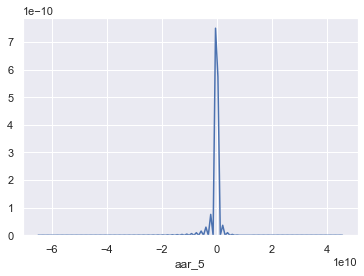

aar_5 range: [-64863896415.11076, 45761542196.09154]


In [7]:
sns.distplot(df['aar_5'], hist = False) ; plt.show()
print("aar_5 range: [{}, {}]".format(df['aar_5'].min(), df['aar_5'].max()))

In [8]:
df = main.remove_outliers(df, range_min=-50 , range_max = 10)

Removed 515 outliers


We can think of aar_5 as how well the stock did on average in a day during the time-window.<br/>
While it make sense that a stock would drop rapidly, it's unlikely for the opposite to occur, therefore we believe that an assymetrical drop around 0 would make the most sense.

**Get to know the data**

We will go over the features in the data and present it.

In [14]:
print("# of companies in data: {}".format(df['company_name'].unique().shape[0]))

# of companies in data: 864


<module 'visualize.visualize' from 'C:\\Users\\Owner\\GIT\\DS3\\DataSci\\visualize\\visualize.py'>

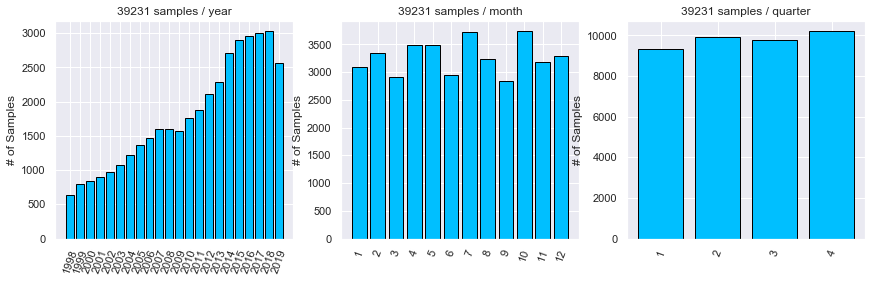

In [17]:
visualize.plot_time_related_hist(df)

**TODO: ANAT** why the data increase with years? 

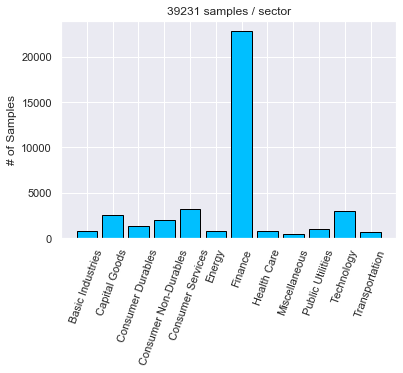

In [18]:
visualize.hist_by_col(df, "sector") ; plt.show()

**TODO: ANAT** so much finance?

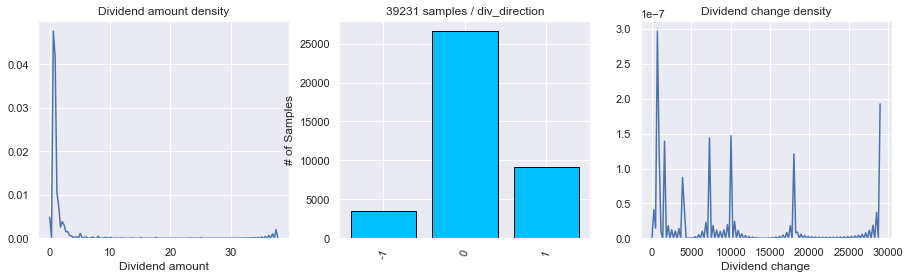

In [19]:
visualize.plot_time_sector_change_hist(df)

**TODO: ANAT**

**Normalizing the abnormal return**

One more thing we had in mind is to normalize the abnormal return, that's why we created "aar_i%",<br/>
which is the same as "aar_i" but divided by the mean of the expected values:<br/>
$aar\_i\% = \frac{aar\_i}{(\sum_{k=-i}^{i}{expected_k})/(2i+1)}$<br/>
The logic behind this is that we want to 'scale' the mistake - it makes more sense to look at the abnormal return as a fraction of the expected price rather than as an absolute value.<br/>

In the graphs below we can see histograms of aar_5/aar_5% gived the direction of the dividend change (increase/decrease/flat). We can see that int the aar_5% the effect of the dividend direction looks greater, this is also reflect if the means.


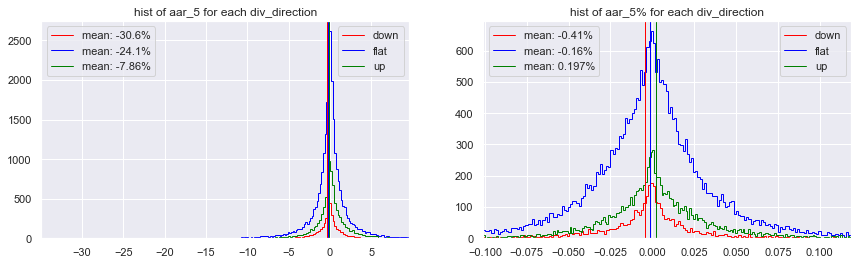

In [20]:
visualize.plot_aar5_and_aar5p_given_dir(df)

We will predict arr_5% instead of aar_5.

**Train/Test Split**<br/>
Before we proceed we will split our data into train and test sets.

In [21]:
df_train, df_test = main.train_test_split(df)

### Step 3: Base line model
This step include two parts:
1. Research replication
2. Run simple linear regression to use as a baseline

Recall we are trying to predict "arr_5", hence we will not use any related features.<br/>
The way the financial ratios were added to the model was based on the 'sector' feature. Therefore is a linear dependency between the 'sector' and 'industry' features to the rest of the financial ratios. In order to avoid avoid instabillity of the model we drop 'sector' and 'industry' features<br/>
Below you can see the features we will use for the baseline prediction.

In [22]:
_ = main.generate_bl_model_data(df, print_ = True, y_col = 'aar_5%')

Baseline model features: {'year_2000', 'Fixed Assets/BV of Capital', 'month_11', 'Capital Spending/BV of Capital', 'month_5', 'div_amount_num', 'Std Deviation In Prices', 'div_direction', 'BV Debt Ratio', 'month_3', 'year_2004', 'month_8', 'MV Debt Ratio', 'month_12', 'year_2009', 'year_2010', 'month_4', 'Effective Tax Rate', 'year_2007', 'year_2002', 'year_2008', 'quarter', 'month_10', 'year_2003', 'EBITDA/Value', 'alpha', 'year_2018', 'div_change', 'year_1999', 'year_2015', 'month_2', 'month_9', 'year_2016', 'year_2005', 'year_2012', 'year_2017', 'beta', 'year_2014', 'year_2001', 'year_2006', 'year_2013', 'month_7', 'year_2011', 'month_6', 'year_2019'}


**Research replication**<br/>
In order to validate our data and make sure it 'make sense', we will try to replicate previous research results.<br/>
To do so - we would need to drop samples where $div\_change = 0$. Using linear regression they recieved R^2 of about 7%, we will try to replicate it.

In [23]:
#Regression model - Research
research_baseline_model_data = main.generate_bl_model_data(df, print_ = False, y_col = 'aar_5')
research_baseline_model_data = research_baseline_model_data[research_baseline_model_data['div_direction'] != 0]
_ = regression_models.run_linear_reg(research_baseline_model_data) 

R^2: 0.05810584723270629


First we can see we got close R squared to previous studies.<br/>
The gap might be explained by the fact that previous studies implemented a more strict dividend policy assumption - a dividend change was considered as such only after two consecutive years of staying at the same level.<br/>
The cost of implementing such a strict dividend policy is losing alot of samples.

**Linear regression as baseline**<br/>
Use simple linear regression on our data:

In [24]:
bl_model_data = main.generate_bl_model_data(df, print_ = False, y_col = 'aar_5%')
bl_model = regression_models.run_linear_reg(bl_model_data, y_col = 'aar_5%')

R^2: 0.011670329912873978


The above result isn't satisfying, we would need to analyze it in two planes:
1. Where did we do especially bad?
2. Revisit our measurment assumption

### Step 4: Analysis of error for the base line model + conclusions (years 2008-2009)
TODO: visualize and discuss

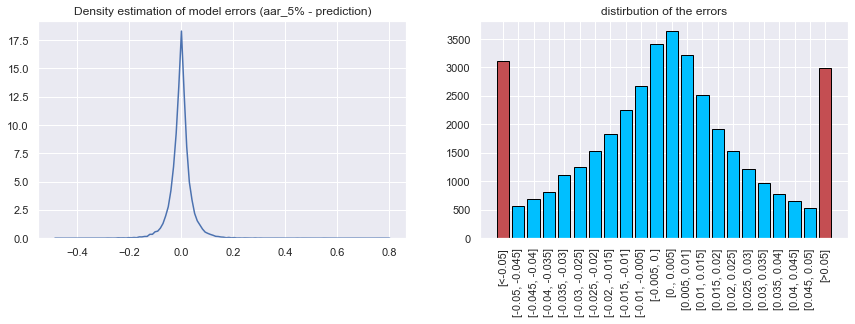

In [25]:
preds = regression_models.predict_linear_reg(bl_model, bl_model_data, y_col = 'aar_5%')
visualize.plot_errors_dist(bl_model_data, preds)

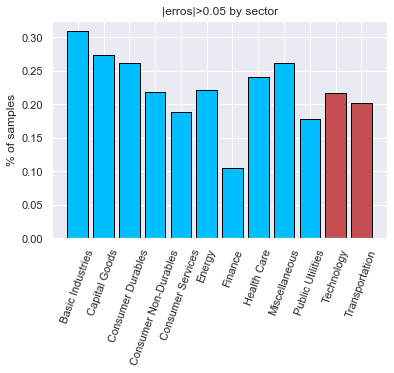

In [34]:
imp.reload(visualize)
visualize.plot_error_by_year(df, preds, by = 'sector')

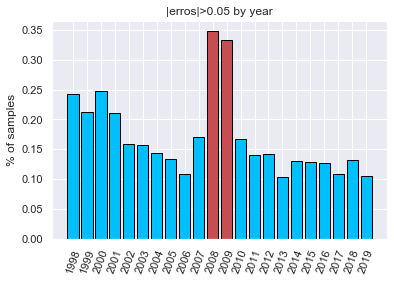

In [53]:
visualize.plot_error_by_year(df, preds)

Run linear regression withuot 2008 - 2009 samples:

In [51]:
imp.reload(visualize)
bl_model_data_no0809, year_col = main.generate_bl_model_data(df, drop_08_09=True, return_year = True,print_ = False, y_col = 'aar_5%')
bl_model_no0809 = regression_models.run_linear_reg(bl_model_data_no0809, y_col = "aar_5%")

R^2: 0.01356927105791328


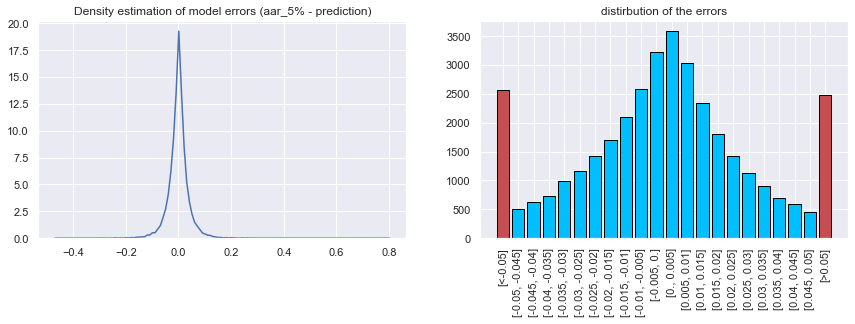

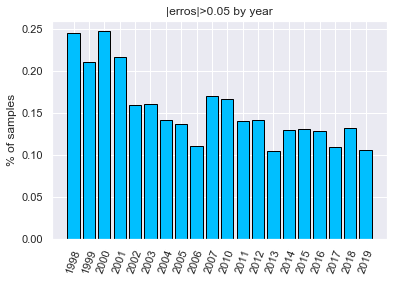

In [52]:
preds_no_0809 = regression_models.predict_linear_reg(bl_model_no0809, bl_model_data_no0809, y_col = 'aar_5%')
bl_model_data_no0809['year'] = year_col
visualize.plot_errors_dist(bl_model_data_no0809, preds_no_0809)
visualize.plot_error_by_year(bl_model_data_no0809, preds_no_0809, color_0809 = False)

### Step 5: Revisiting measurment assumptions - Sensitivity analysis (size of window)

The measurment assumption we would like to revisit is the windows size around the annoucement.<br/>
As of now the window size if fixed to five days post and prior to the day of the dividend annoucment. There's a reason to believe that other window size (symmetrical or not) will correspond better with our goal - measuring the abnoraml return (more on that in the PDF documentation).
Below, you can see the average normalized abnormal return ("aar_i%") gived the dividend change direction, for different window sizes.

In [54]:
_ =visualize.window_analysis(feature_handler.create_asymmetric_window(df, -1, 5), 'asy')

      aar_0%  aar_1%  aar_2%  aar_3%  aar_4%  aar_5%  aar_asy-1_5%
down   -0.41   -0.43   -0.43   -0.41   -0.41   -0.41         -0.47
flat   -0.16   -0.16   -0.15   -0.15   -0.14   -0.14         -0.13
up      0.07    0.13    0.15    0.18    0.20    0.21          0.31


In [55]:
imp.reload(main)

<module 'main' from 'C:\\Users\\Owner\\GIT\\DS3\\DataSci\\main.py'>

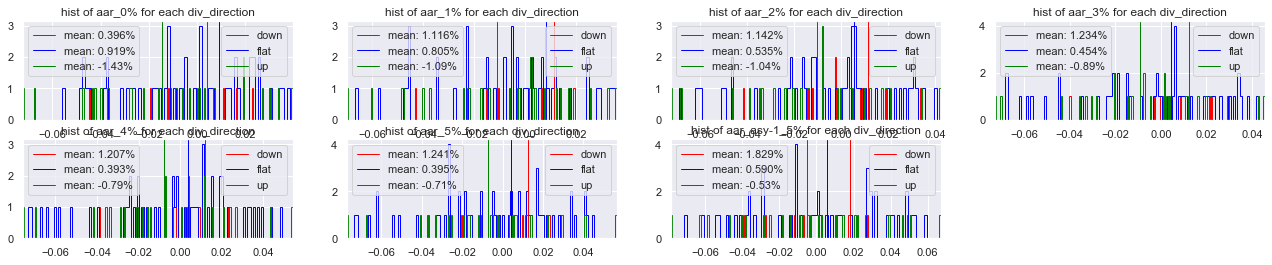

In [56]:
main.plot_ws_by_div_dir(df[:100])

From the table above we can see that the rightmost column - the asymmetrical window, shows the most consistent trends with our apriori believes. 

In [283]:
start, end = -1 ,5
y_col = "aar_asy{}_{}%".format(str(start), str(end))
baseline_data_ws = main.generate_bl_model_data(df_aar_5_precent_no_outliers,\
                                                             window_size=(start, end),\
                                                             drop_08_09 = True,
                                                             print_ = 0)
_ = regression_models.run_linear_reg(baseline_data_ws, y_col = y_col)

R^2: 0.15456866644493816


Although the results are not promising just yet, them major advantage is that using the new window size let us use more information closer to the announcment time (t-4 and t-5).
Trying to fit linear regression to the other window sizes result in smiliar results:

In [284]:
for ws, y_col in [(1,'aar_1%'), (2, 'aar_2%'), ((-1,5) ,"aar_asy{}_{}%".format(*(-1,5)))]:
    baseline_data_ws1 = main.generate_bl_model_data(df,
                                                 window_size=ws,
                                                 y_col=y_col,
                                                 delta_precentage = False,
                                                 drop_08_09 = True,
                                                 print_ = 0)
    print("Window: "+str(ws), end = ', ')
    _ = regression_models.run_linear_reg(baseline_data_ws1, y_col = y_col, print_summary= 0)

Window: 1, R^2: 0.20665807366640032
Window: 2, R^2: 0.18693973222015614
Window: (-1, 5), R^2: 0.15456866644493816


### Step 6: Run new model (Regression) (naive + feature handler)

We will consider two new features, since we normalized our response, it's make sense to also normalize in the same way the new features that were added from the window size change.<br/>
$delta\_\%\_{t-5}=\frac{price_{t-5} - expected_{t-5}}{expected_{t-5}}$

$delta\_\%\_{t-4}=\frac{price_{t-4} - expected_{t-4}}{expected_{t-4}}$

In [124]:
ws, y_col = ((-1,5) ,"aar_asy{}_{}%".format(*ws))
baseline_data_ws = main.generate_bl_model_data(df,
                                             window_size=ws,
                                             y_col=y_col,
                                             delta_precentage = True,
                                             drop_08_09 = True,
                                             print_ = 0)
_ = regression_models.run_linear_reg(baseline_data_ws, y_col = y_col)

R^2: 0.38973192622120045


**#TODO: ANAT**

In [125]:
baseline_data_ws1 = main.generate_bl_model_data(df,
                                             window_size=1,
                                             y_col='aar_1%',
                                             delta_precentage = True,
                                             drop_08_09 = True,
                                             print_ = 0)
print("Window: "+str(1), end = ', ')
_ = regression_models.run_linear_reg(baseline_data_ws1, y_col = 'aar_1%', print_summary= 0)

Window: 1, R^2: 0.5124827747377475


Seems like that gave us a big improvment.<br/>
That's raise some thoughts about the importance of the other features, using Recursive Feature Elimination gets $delta\_\%\_{t-4}$ as the highest ranking feature

In [126]:
regression_models.rfe(baseline_data_ws, y_col, n_features_to_select=5)

{'ar_t-5', 'delta_%_t-4', 'delta_%_t-5', 'expected_t-5', 'price_t-5'}

Running linear regression using only 'delta_%_t-4' support this decision:

In [132]:
_ = regression_models.run_linear_reg(baseline_data_ws[['delta_%_t-4', y_col]], y_col = y_col, print_summary= 0)

R^2: 0.38595617677789495


We will issue two points:
* The finnancial explanation behind it - since for most of our samples $div\_direction=0$, it means that 

**#TODO: ANAT**

### Step 7: Run different Regression models and compare
Now we want to leave the linear regression model, and use more complex models.<br/>
First we will split the data into train and test.

In [324]:
ws = (-1,5) 
y_col = "aar_asy{}_{}%".format(*ws)
pred_data = main.generate_bl_model_data(df,
                                         window_size=ws,
                                         y_col=y_col,
                                         delta_precentage = True,
                                         drop_08_09 = True,
                                         print_ = 0)
X_train, X_test, y_train, y_test = main.split_test_train(pred_data, y_col = y_col, test_size = 0.33)

Next we will introduce new baseline models:<br/>
* The First one will be a simple linear regression, using only the variable 'delta_%_t-4'
* The second one will be a constant model which always predict the mean value of y_train.<br/>

In addition we will now look at the mean squared error instead of the R squared we looked at before. We want to compare models that aren't linear regression. In praticular we will examine the mse*(10^4) because the scale if very small.

In [204]:
bl_model_lg, bl_model_const = regression_models.step7_bl_models(X_train, X_test, y_train, y_test)

Linear Regression model mse*e+4: 15.39714828401666
Constant model mse*e+4: 25.10803161952498


We examined few models, such as: MLP Regressor, XGBoost and Random Forest.<br/>
We didn't get better results than our baselines, but we could see that the models that got good results 'converged' to one of the baseline models.<br/>
We decided to first use our linear regression baseline model and then predict it's error:

In [205]:
y_delta_train = y_train - bl_model_lg.predict(X_train[['delta_%_t-4']])
y_delta_test = y_test - bl_model_lg.predict(X_test[['delta_%_t-4']])

After considering few models, Random Forest gave us the best results:

In [319]:
rf_model = main.fit_rf(X_train, y_delta_train, n_estimators=10, run_speed =1)
display(rf_model)
predictions = rf_model.predict(X_test) + bl_model_lg.predict(X_test[['delta_%_t-4']])
print("Total mse using lr+rf: {}".format(regression_models.mse(predictions, y_test)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Total mse using lr+rf: 16.226109886954152


### Step 8: Discrete Models

### Step 9: Cross Validation, results and conclusions